In [48]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os, json

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers
from pprint import pprint

import functions as fn

# Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)

# Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()



In [2]:
## Load the autoreload extension
%load_ext autoreload
%autoreload 2

In [61]:
from pprint import pprint
FPATHS = dict(
    data={
        "processed": "Data/movie_reviews.joblib",
        "ml": {
            "train": "Data/training-data.joblib",  
            "test": "Data/testing-data.joblib",
            
            "label_encoder":"Data/label-encoder.joblib",
            'target_lookup':"Data/target-lookup-dict.joblib",
            
        },
        "tf": {
            "train_tf": "Data/training_tf",  
            "test_tf": "Data/testing_tf", 
         },           
    },
    models={
        "clf": "models/clf-pipe.joblib", 
        "gru": "models/tf/",
        "gsv": "models/gsv-pipe.joblib",
    },
    
)
pprint(FPATHS)

{'data': {'ml': {'label_encoder': 'Data/label-encoder.joblib',
                 'target_lookup': 'Data/target-lookup-dict.joblib',
                 'test': 'Data/testing-data.joblib',
                 'train': 'Data/training-data.joblib'},
          'processed': 'Data/movie_reviews.joblib',
          'tf': {'test_tf': 'Data/testing_tf', 'train_tf': 'Data/training_tf'}},
 'models': {'clf': 'models/clf-pipe.joblib',
            'gru': 'models/tf/',
            'gsv': 'models/gsv-pipe.joblib'}}


In [4]:
os.makedirs('config/', exist_ok=True)
FPATHS_FILE = 'config/filepaths.json'
with open(FPATHS_FILE, 'w') as f:
    json.dump(FPATHS, f)

In [5]:
# Using function from Creating a File Structure Lesson
fn.create_directories_from_paths(FPATHS)

In [6]:
# loading processed data
fpath = FPATHS['data']['processed']
df = joblib.load(fpath)
df.head()

,review_id,movie_id,imdb_id,original_title,review,rating,ratings,lower,tokens,tokens_as_strings,clean,lemmas,lemmas-joined,tokens_joined
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0,high,"a guilty pleasure for me personally, as i love...","[a, guilty, pleasure, for, me, personally, ,, ...","a , guilty , pleasure , for , me , personally ...",a guilty pleasure for me personally as...,"[guilty, pleasure, personally, love, great, es...",guilty pleasure personally love great escape w...,"a guilty pleasure for me personally , as i lov..."
6,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straig...",3.0,low,"the first underwhelmed me, but this one straig...","[the, first, underwhelmed, me, ,, but, this, o...","the , first , underwhelmed , me , , , but , th...",the first underwhelmed me but this one...,"[underwhelme, straightup, bore, course, see, h...",underwhelme straightup bore course see hunt cl...,"the first underwhelmed me , but this one strai..."
7,5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,After quite entertainign Mission Impossible I ...,2.0,low,after quite entertainign mission impossible i ...,"[after, quite, entertainign, mission, impossib...","after , quite , entertainign , mission , impos...",after quite entertainign mission impossibl...,"[entertainign, mission, impossible, second, in...",entertainign mission impossible second install...,after quite entertainign mission impossible i ...
15,608e2744d8cc4a0058dc4272,2621,tt0122459,Return to Me,"Okay, I will admit I can be a bit of an easy g...",9.0,high,"okay, i will admit i can be a bit of an easy g...","[okay, ,, i, will, admit, i, can, be, a, bit, ...","okay , , , i , will , admit , i , can , be , a...",okay i will admit i can be a bit of...,"[okay, admit, bit, easy, grader, come, romanti...",okay admit bit easy grader come romantic comed...,"okay , i will admit i can be a bit of an easy ..."
20,6409202f0e441900e887a17b,4234,tt0134084,Scream 3,**_Scream 3’s_ lackluster screenplay and unima...,4.0,low,**_scream 3’s_ lackluster screenplay and unima...,"[*, *, _scream, 3, ’, s_, lackluster, screenpl...","* , * , _scream , 3 , ’ , s_ , lackluster , sc...",scream 3 s lackluster screenplay an...,"[scream, 3, s, lackluster, screenplay, unimagi...",scream 3 s lackluster screenplay unimaginative...,* * _scream 3 ’ s_ lackluster screenplay and u...


In [7]:
## Check class balance of 'rating'
df['ratings'].value_counts(normalize=True)

low     0.505994
high    0.494006
Name: ratings, dtype: float64

In [8]:
# assign X and y
X = df['review']
y = df['ratings']

In [9]:
# train test split
X_train, X_test, y_train_str, y_test_str = train_test_split(X,y,test_size=0.25,
                                                    random_state=42)

In [10]:
# Getting unique classes to convert
class_names = y_train_str.unique()
class_names

array(['low', 'high'], dtype=object)

In [11]:
# Fit the label encoder on unique class names
encoder = LabelEncoder()
encoder.fit(class_names)

LabelEncoder()

In [12]:
# Transform the y_train_str and y_test_str with encoder
y_train = encoder.transform(y_train_str)
y_test = encoder.transform(y_test_str)
y_train[:10]

array([1, 0, 0, 0, 1, 0, 0, 0, 1, 0])

In [13]:
classes = encoder.classes_
classes

array(['high', 'low'], dtype=object)

In [14]:
# Get the encoded values for each both classes
class_codes = encoder.transform(classes)
class_codes

array([0, 1])

In [15]:
# Making lookup dictionary to find the encoded label's original name
target_lookup = dict(zip(class_codes,classes ))
target_lookup

{0: 'high', 1: 'low'}

In [16]:
# saving
fpath_train = FPATHS['data']['ml']['train']
joblib.dump([X_train, y_train], fpath_train)
fpath_test = FPATHS['data']['ml']['test']
joblib.dump([X_test, y_test], fpath_test)

['Data/testing-data.joblib']

In [17]:
def load_Xy_data(joblib_fpath):
    return joblib.load(joblib_fpath)
# Load training data from FPATHS
train_data_fpath  = FPATHS['data']['ml']['train']
X_train, y_train = load_Xy_data(train_data_fpath)
# Load test data from FPATHS
test_data_fpath  = FPATHS['data']['ml']['test']
X_test, y_test = load_Xy_data(test_data_fpath)

In [18]:
fpath_encoder = FPATHS['data']['ml']['label_encoder']
joblib.dump(encoder, fpath_encoder)
fpath_lookup = FPATHS['data']['ml']['target_lookup']
joblib.dump(target_lookup, fpath_lookup)

['Data/target-lookup-dict.joblib']

## Machine Learning Model

In [19]:
## Create a pipeline with a vectorizer and classification model.
clf_pipe = Pipeline([('vectorizer', CountVectorizer(stop_words='english')),
                     ('clf',RandomForestClassifier(random_state=42))])
clf_pipe

Pipeline(steps=[('vectorizer', CountVectorizer(stop_words='english')),
                ('clf', RandomForestClassifier(random_state=42))])

In [20]:
# fit model pipeline
clf_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(stop_words='english')),
                ('clf', RandomForestClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       888
           1       1.00      1.00      1.00       926

    accuracy                           1.00      1814
   macro avg       1.00      1.00      1.00      1814
weighted avg       1.00      1.00      1.00      1814



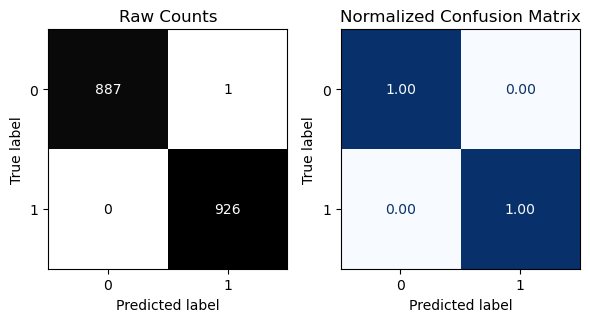


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       307
           1       0.84      0.82      0.83       298

    accuracy                           0.84       605
   macro avg       0.84      0.84      0.84       605
weighted avg       0.84      0.84      0.84       605



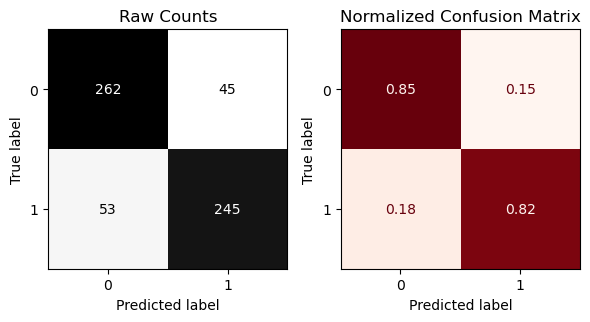

In [21]:
# evaluate model
fn.evaluate_classification(clf_pipe, X_train,y_train, X_test, y_test)

In [22]:
# Save the model
fpath_ml_pipe = FPATHS['models']['clf']
joblib.dump(clf_pipe, fpath_ml_pipe)

['models/clf-pipe.joblib']

## Deep NLP Model

In [23]:

# instantiate LabelEncoder
encoder = LabelEncoder()

In [24]:
# Fit and Transform the strings into integers
y = pd.Series(encoder.fit_transform(y))
y.value_counts()

1    1224
0    1195
dtype: int64

In [25]:
# Convert to Dataset object
ds = tf.data.Dataset.from_tensor_slices((X, y))
ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [26]:
# shuffle data once
ds = ds.shuffle(buffer_size=len(ds), reshuffle_each_iteration=False)

In [27]:
# Add a column to the dataframe that has the length of each paragraph
df['sequence_length'] = df['review'].map( lambda x: len(x.split(" ")))

In [28]:
df['sequence_length'].describe()

count    2419.000000
mean      225.767673
std       270.815728
min         1.000000
25%        62.000000
50%       143.000000
75%       286.500000
max      4017.000000
Name: sequence_length, dtype: float64

In [29]:
# maximum length = sequence length max
SEQUENCE_LENGTH = 4017

In [30]:
# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )

In [31]:
# Calculate the number of samples for training and validation data
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)

In [32]:
# Set the batch size
BATCH_SIZE =32

In [33]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)

# Skip over the training batches and take the validation batches
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)

# Skipver the train and validation batches, the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)

In [34]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)

In [35]:
# Create keras text Vectorization layer
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

In [36]:
# Save training dataset object
train_ds_fpath = FPATHS['data']['tf']['train_tf']
tf.data.Dataset.save(train_ds, train_ds_fpath)
# Save testing dataset object
test_ds_fpath = FPATHS['data']['tf']['test_tf']
tf.data.Dataset.save(test_ds, test_ds_fpath)

In [37]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)

In [38]:
# Create keras text Vectorization layer
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

In [39]:
# Fit/Adapt the text vectorization layer on the training texts.
sequence_vectorizer.adapt(ds_texts)

In [40]:
# Save the vocabulary size from the layer to use in your models' Embedding layer.
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()

In [41]:
# unique classes
classes = y.unique()
classes

array([0, 1])

In [42]:
# Function - using the model that performed best in core projects
def build_gru_model_bi_pool(text_vectorization_layer):

    gru_model_bi_pool = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                      output_dim=EMBED_DIM,
                      input_length=SEQUENCE_LENGTH)])

    # Add bidirectional component to GRU layer
    gru_model_bi_pool.add(layers.Bidirectional(layers.GRU(64, return_sequences = True)))
    gru_model_bi_pool.add(layers.Dropout(.2))
    gru_model_bi_pool.add(layers.Bidirectional(layers.GRU(32, return_sequences = True)))
    # Add a pooling layer *new
    gru_model_bi_pool.add(layers.GlobalMaxPooling1D())

    # Output layer
    gru_model_bi_pool.add(layers.Dense(len(classes), activation='softmax'))

    optimizer = optimizers.legacy.Adam()
    gru_model_bi_pool.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model_bi_pool.summary()
    return gru_model_bi_pool

In [43]:
EMBED_DIM = 100
#Build the model
model = build_gru_model_bi_pool(sequence_vectorizer)
# Fit the model
EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=fn.get_callbacks(),
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 4017)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 4017, 100)         2492300   
                                                                 
 bidirectional (Bidirectiona  (None, 4017, 128)        63744     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 4017, 128)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4017, 64)         31104     
 nal)                                                            
                                                        

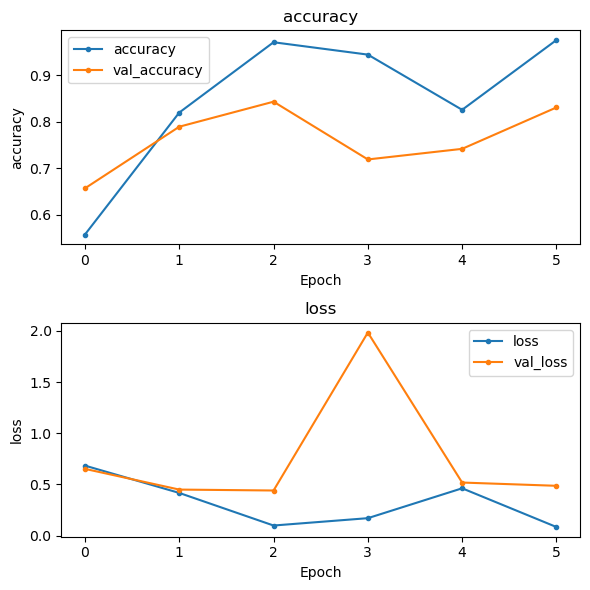


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       856
           1       1.00      1.00      1.00       837

    accuracy                           1.00      1693
   macro avg       1.00      1.00      1.00      1693
weighted avg       1.00      1.00      1.00      1693



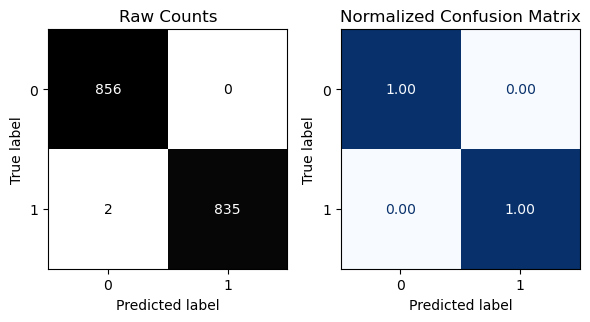


- Evaluating Training Data:
53/53 [==============================] - 57s 1s/step - loss: 0.0084 - accuracy: 0.9988
{'loss': 0.008370901457965374, 'accuracy': 0.9988186359405518}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.85      0.80       113
           1       0.85      0.76      0.80       130

    accuracy                           0.80       243
   macro avg       0.80      0.81      0.80       243
weighted avg       0.81      0.80      0.80       243



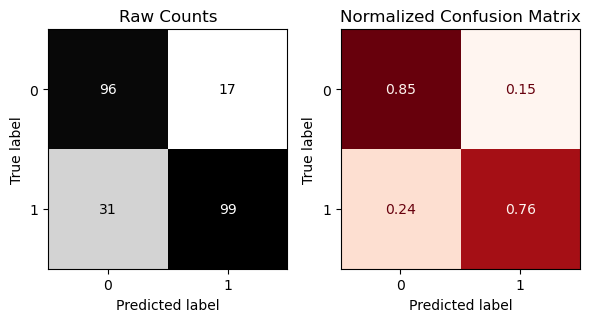


- Evaluating Test Data:
8/8 [==============================] - 9s 1s/step - loss: 0.5782 - accuracy: 0.8025
{'loss': 0.5782195329666138, 'accuracy': 0.8024691343307495}


In [44]:
# Evaluate the model
results = fn.evaluate_classification_network(
    model, X_train=train_ds,
    X_test=test_ds, history=history);

In [45]:
# Save the model
fpath_nlp_pipe = FPATHS['models']['gru']
tf.keras.models.save_model(model, fpath_nlp_pipe, save_format='tf')

INFO:tensorflow:Assets written to: models/tf/assets


INFO:tensorflow:Assets written to: models/tf/assets


## GCV Model

In [53]:
# Define params to try
param_grid_shared = {
    "vectorizer__max_df": [0.6, 0.7, 0.8],
    "vectorizer__min_df": [2,3,4],
    "vectorizer__max_features": [None, 1000, 2000],
    "vectorizer__stop_words": [None,'english'],
    "vectorizer__ngram_range": [(1, 1), (1, 2), (1,3)]
}

In [54]:
# Setting params for the count vectorizer
param_grid_count = {
    'vectorizer':[CountVectorizer()],
    **param_grid_shared
}

In [55]:
# Set up Pipeline to allow GridSearching
v_pipe = Pipeline([('vectorizer', CountVectorizer()),
                     ('clf',RandomForestClassifier(random_state=42))])

In [56]:
%%time
# Create grid search
grid_search = GridSearchCV(v_pipe, param_grid_shared, cv=2, scoring = 'accuracy', verbose=1, n_jobs=-1)

CPU times: total: 0 ns
Wall time: 0 ns


In [57]:
%%time
# Fit the model
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 162 candidates, totalling 324 fits
CPU times: total: 4.98 s
Wall time: 3min 31s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'vectorizer__max_df': [0.6, 0.7, 0.8],
                         'vectorizer__max_features': [None, 1000, 2000],
                         'vectorizer__min_df': [2, 3, 4],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'vectorizer__stop_words': [None, 'english']},
             scoring='accuracy', verbose=1)

In [58]:
# what were the best params?
grid_search.best_params_

{'vectorizer__max_df': 0.6,
 'vectorizer__max_features': 1000,
 'vectorizer__min_df': 4,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__stop_words': 'english'}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       888
           1       1.00      1.00      1.00       926

    accuracy                           1.00      1814
   macro avg       1.00      1.00      1.00      1814
weighted avg       1.00      1.00      1.00      1814



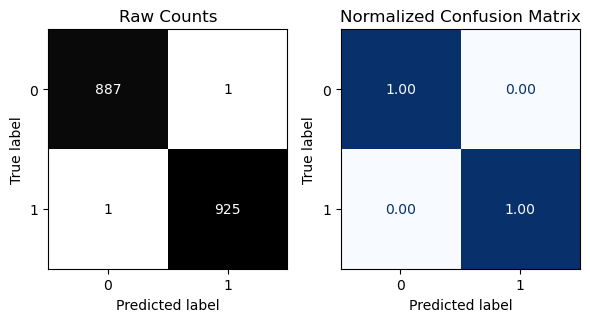


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       307
           1       0.82      0.82      0.82       298

    accuracy                           0.83       605
   macro avg       0.83      0.83      0.83       605
weighted avg       0.83      0.83      0.83       605



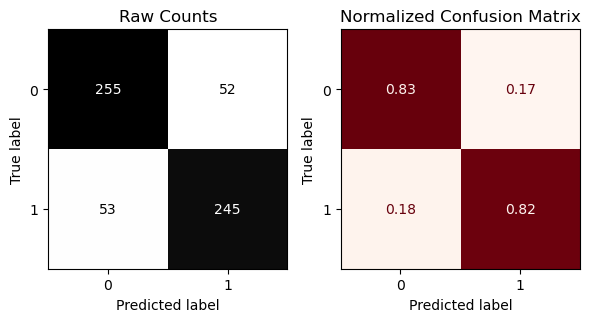

In [59]:
best_model = grid_search.best_estimator_

fn.evaluate_classification(best_model,X_train,y_train,X_test,y_test)

In [62]:
# Save the model
fpath_ml_pipe = FPATHS['models']['gsv']
joblib.dump(v_pipe, fpath_ml_pipe)

['models/gsv-pipe.joblib']

C:\Users\dmusl\anaconda3\envs\dojo-env\lib\site-packages\joblib\_memmapping_reducer.py:607: UserWarning: Failed to delete temporary folder: C:\Users\dmusl\AppData\Local\Temp\joblib_memmapping_folder_8376_66e089edd2144f04b3cf73bb412f8548_36d8bb17f5b44f66acefce9692412cc6
  warnings.warn("Failed to delete temporary folder: {}"
C:\Users\dmusl\anaconda3\envs\dojo-env\lib\site-packages\joblib\_memmapping_reducer.py:607: UserWarning: Failed to delete temporary folder: C:\Users\dmusl\AppData\Local\Temp\joblib_memmapping_folder_8376_66e089edd2144f04b3cf73bb412f8548_f653b00b6dca4bf5acbeef98c7ac389e
  warnings.warn("Failed to delete temporary folder: {}"
